In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

In [2]:
# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_churn = pd.read_csv("//Users/fatemi/Desktop/Loyalist study data/my personal projects/data/Telco_customer_churn.csv")
df_churn.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
# List of columns to drop
columns_to_drop = ['CustomerID', 'Count', 'Country', 'State', 'Lat Long', 'Zip Code', 'Churn Label', 'City', 'Latitude', 'Longitude', 'Churn Score', 'Churn Reason']  # Adjust the list based on your dataset

# Drop the columns
data = df_churn.drop(columns=columns_to_drop)

# Verify the remaining columns
data.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,3239
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2701
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,5372
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,5003
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,5340


In [5]:
# Check for missing values
missing_data = data.isnull().sum()
print(missing_data)

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64


In [6]:
missing_data_col = []
for col in data.columns:
    if data[col].dtype == 'object':  # Check if column is of string type
        # Check for empty strings or strings with only spaces
        blank_rows = data[data[col].str.strip() == '']  # Strip spaces and check for blank strings
        # Check for NaN values
        nan_rows = data[data[col].isna()]
        
        # If there are any blank or NaN rows, print them
        if not blank_rows.empty or not nan_rows.empty:
            missing_data_col.append(col)
            print("missing_data_col:", missing_data_col)
            print(f"Blank or NaN values found in column '{col}'")

missing_data_col: ['Total Charges']
Blank or NaN values found in column 'Total Charges'


In [7]:
data["Total Charges"] = pd.to_numeric(data["Total Charges"], errors = 'coerce')
print(data['Total Charges'].isna().sum())

11


In [8]:
for col in missing_data_col:
    data.loc[(data[col].isna()) & (data['Tenure Months'] == 0), col] = 0

In [9]:
data.dtypes

Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
CLTV                   int64
dtype: object

In [10]:
# Convert categorical columns to 'category'
categorical_cols = ['Gender', 'Internet Service', 'Contract', 'Payment Method']
for col in categorical_cols:
    data[col] = data[col].astype('category')

data.dtypes

Gender               category
Senior Citizen         object
Partner                object
Dependents             object
Tenure Months           int64
Phone Service          object
Multiple Lines         object
Internet Service     category
Online Security        object
Online Backup          object
Device Protection      object
Tech Support           object
Streaming TV           object
Streaming Movies       object
Contract             category
Paperless Billing      object
Payment Method       category
Monthly Charges       float64
Total Charges         float64
Churn Value             int64
CLTV                    int64
dtype: object

In [11]:
# Label Encoding for binary variables

data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
binary_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
for col in binary_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

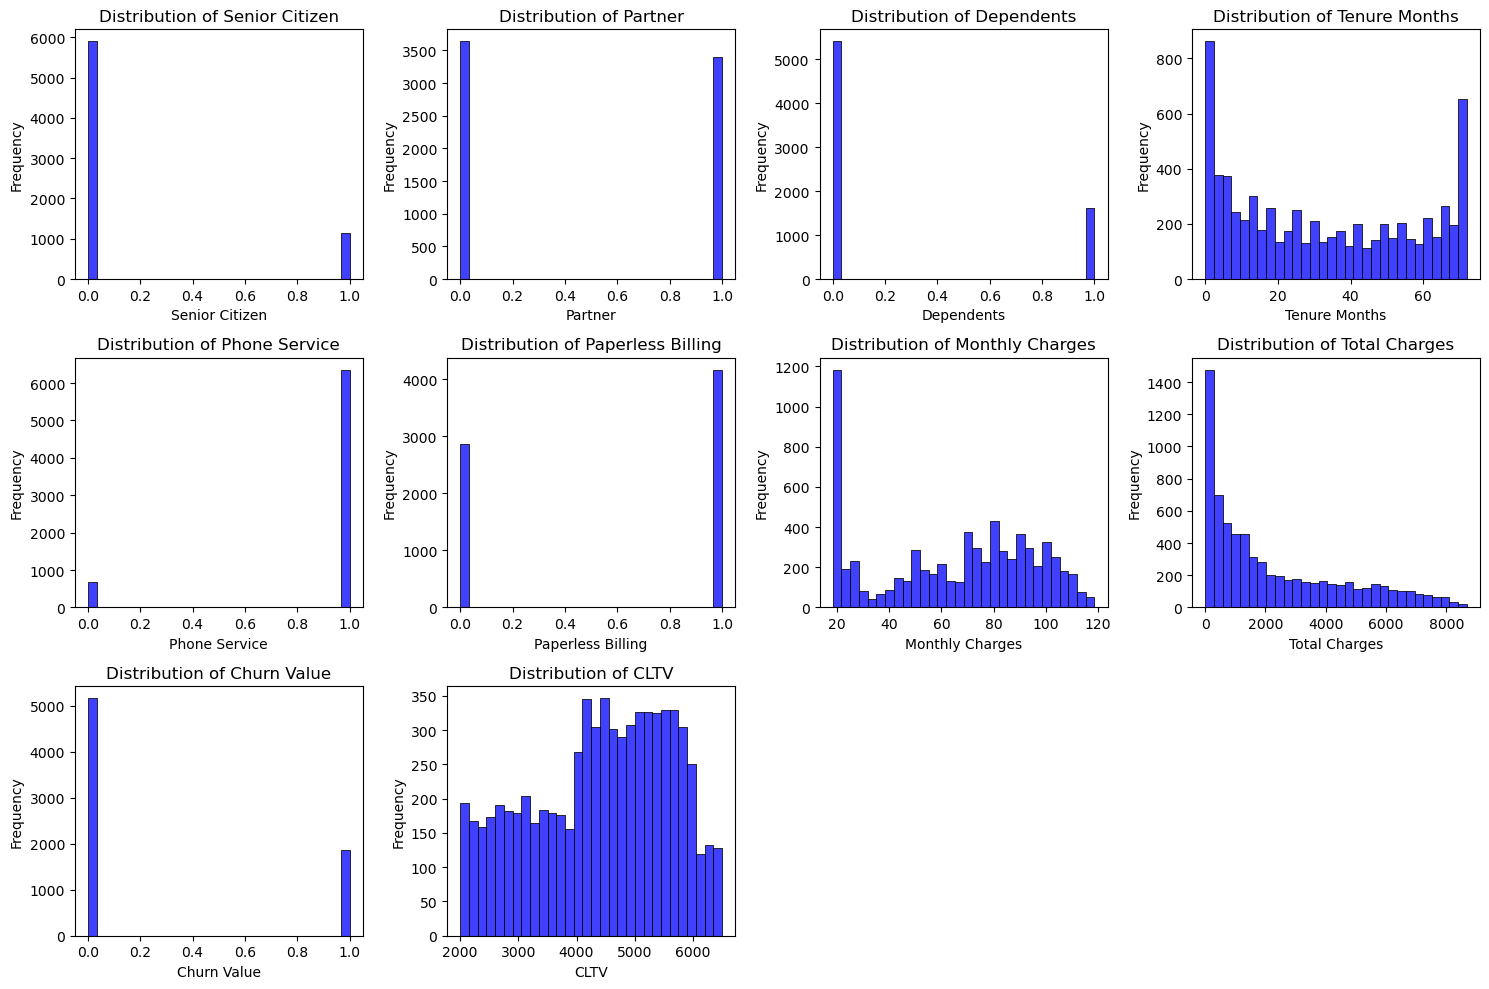

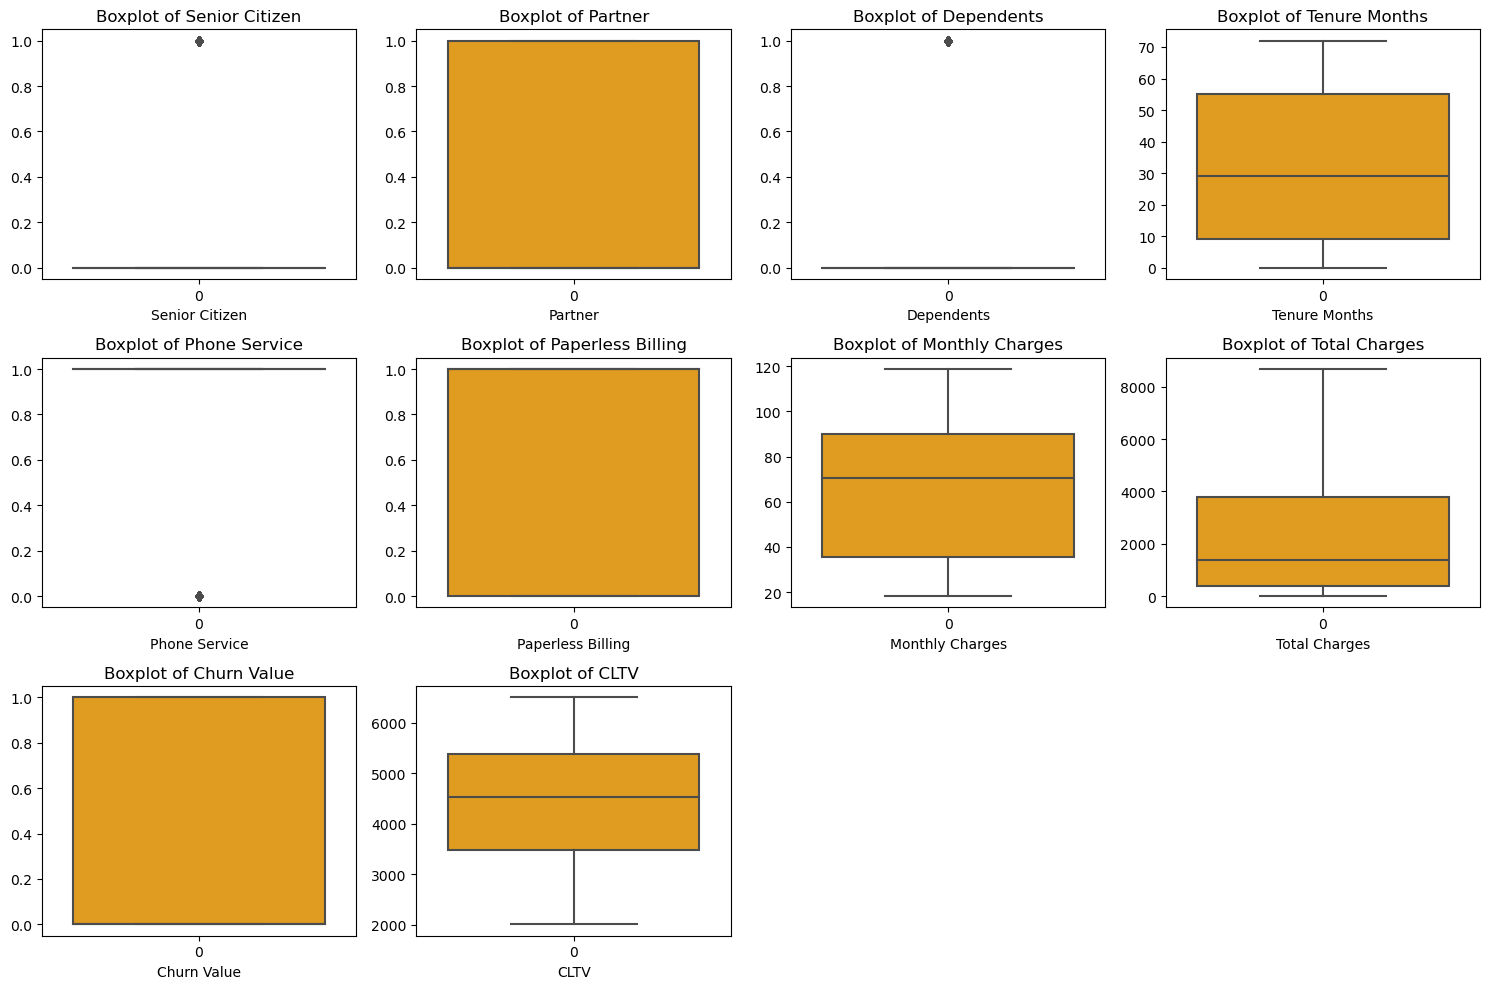

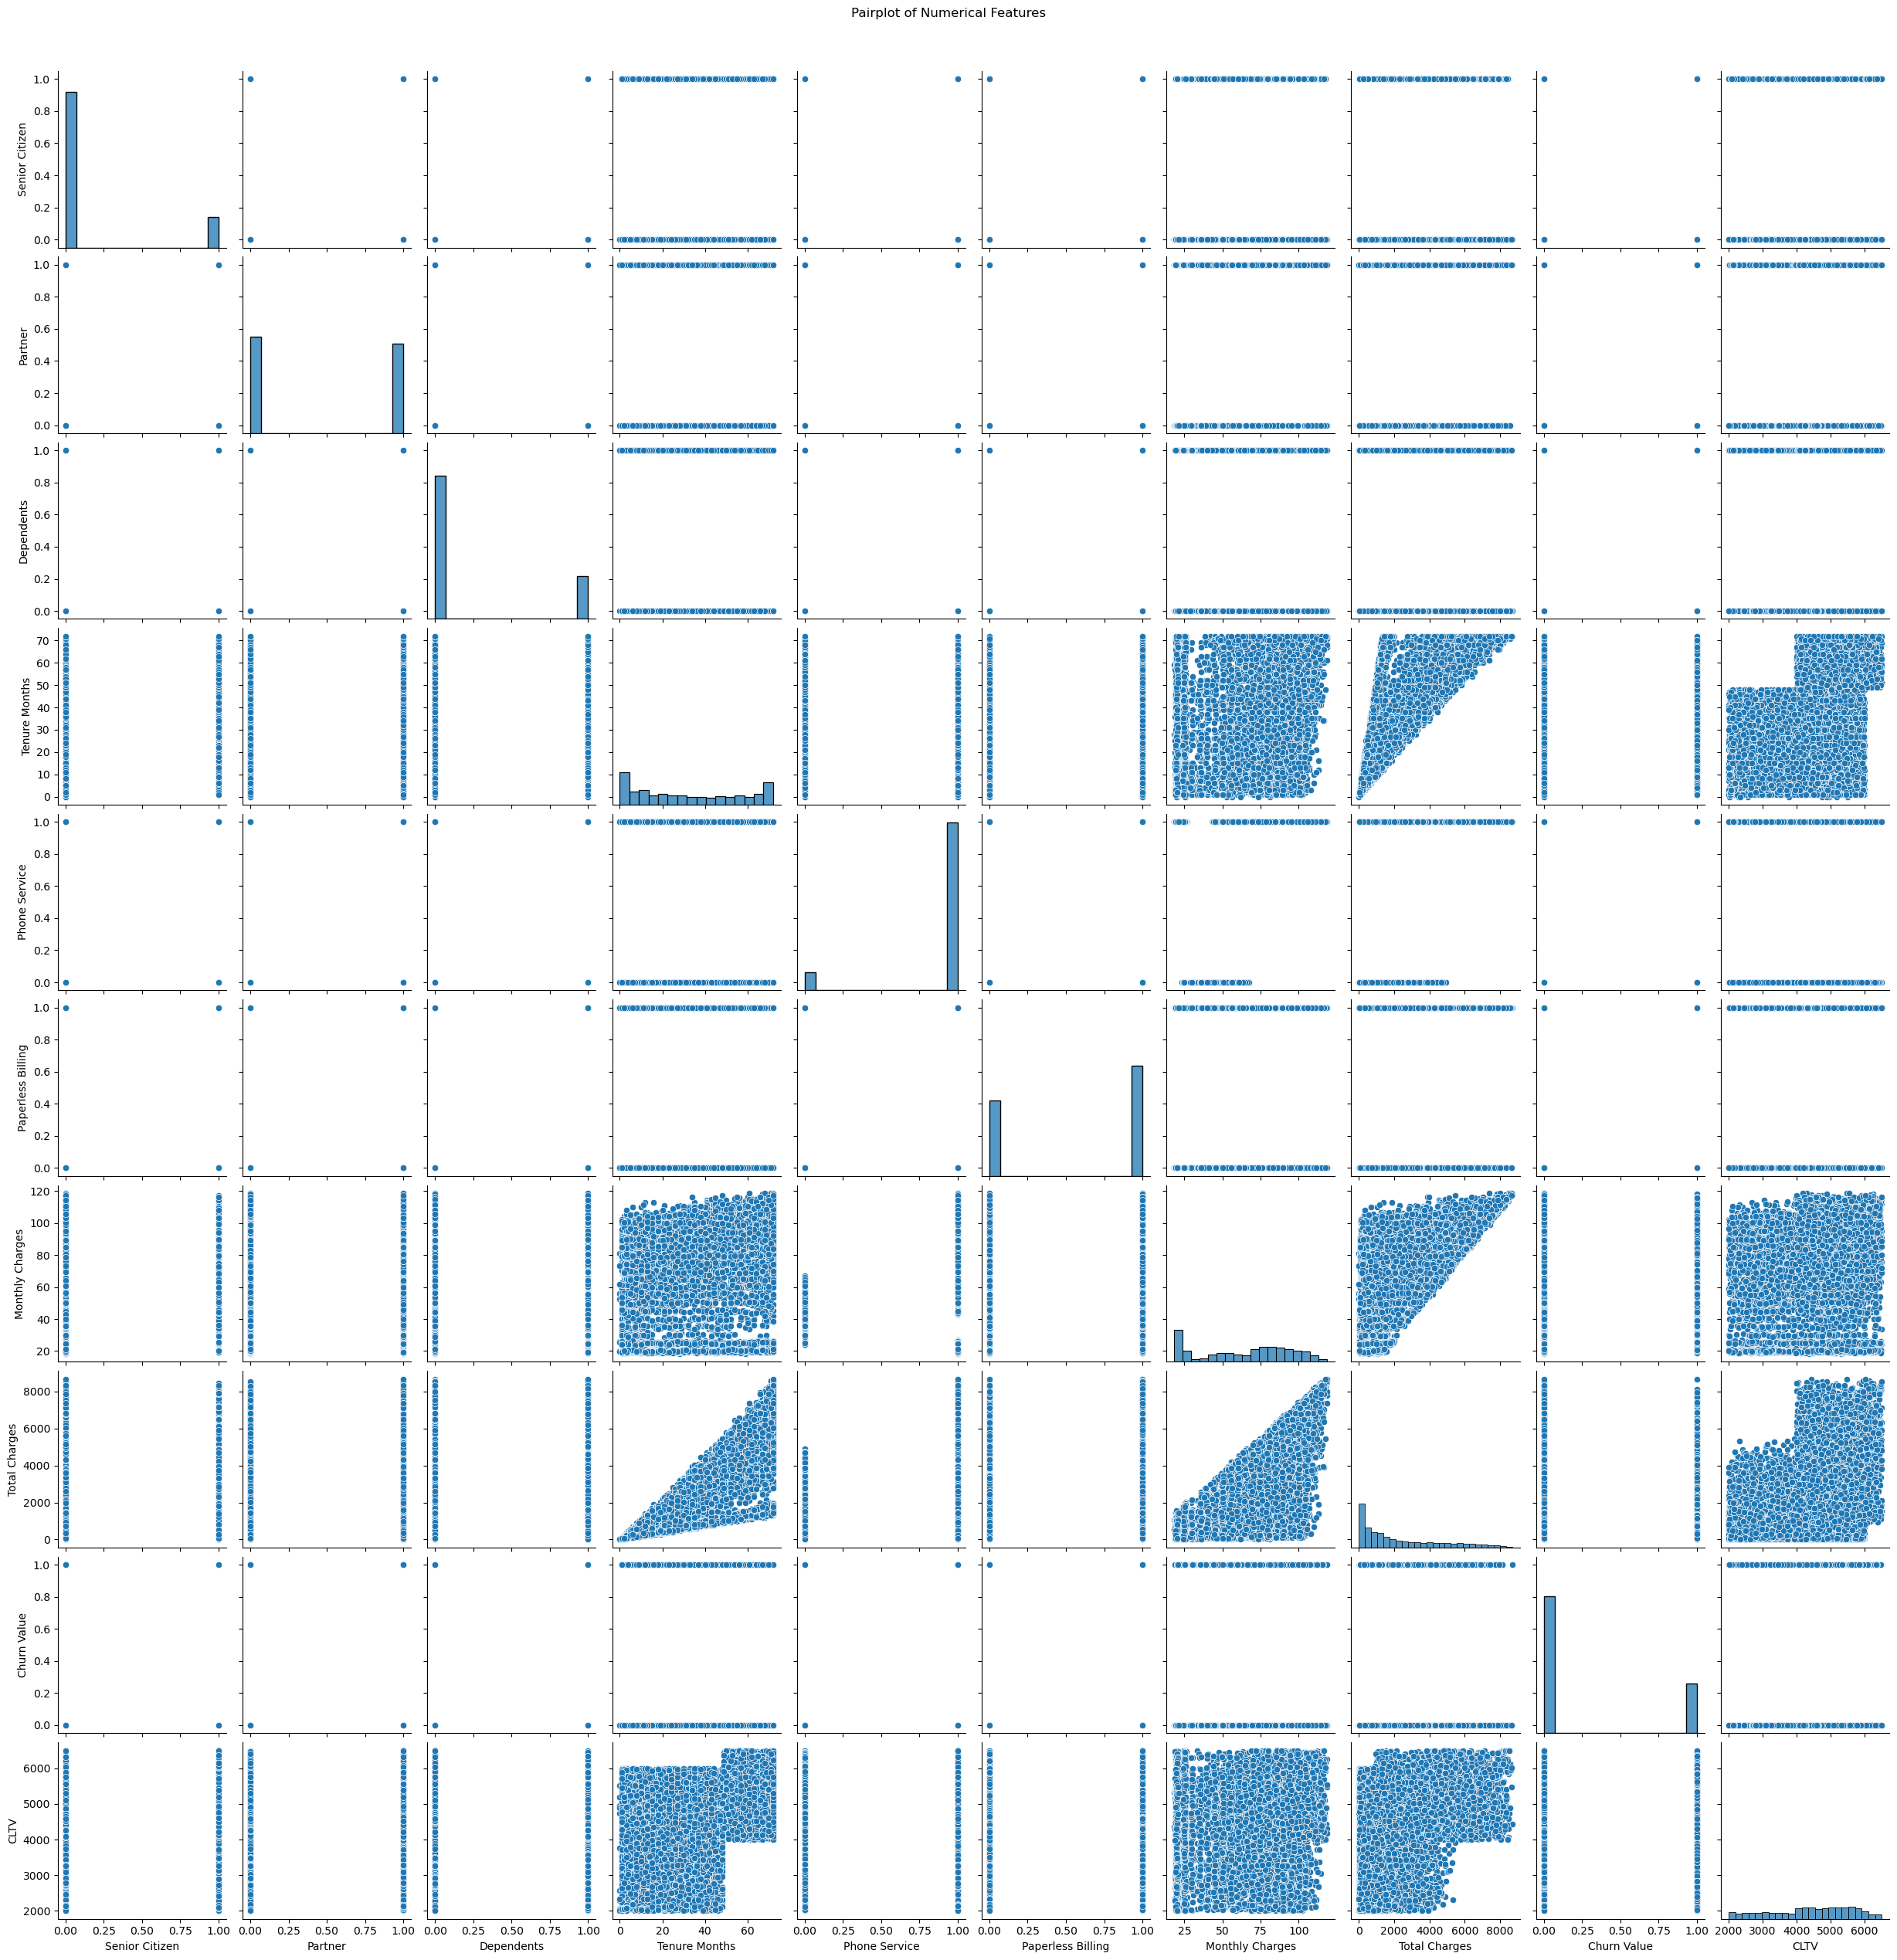

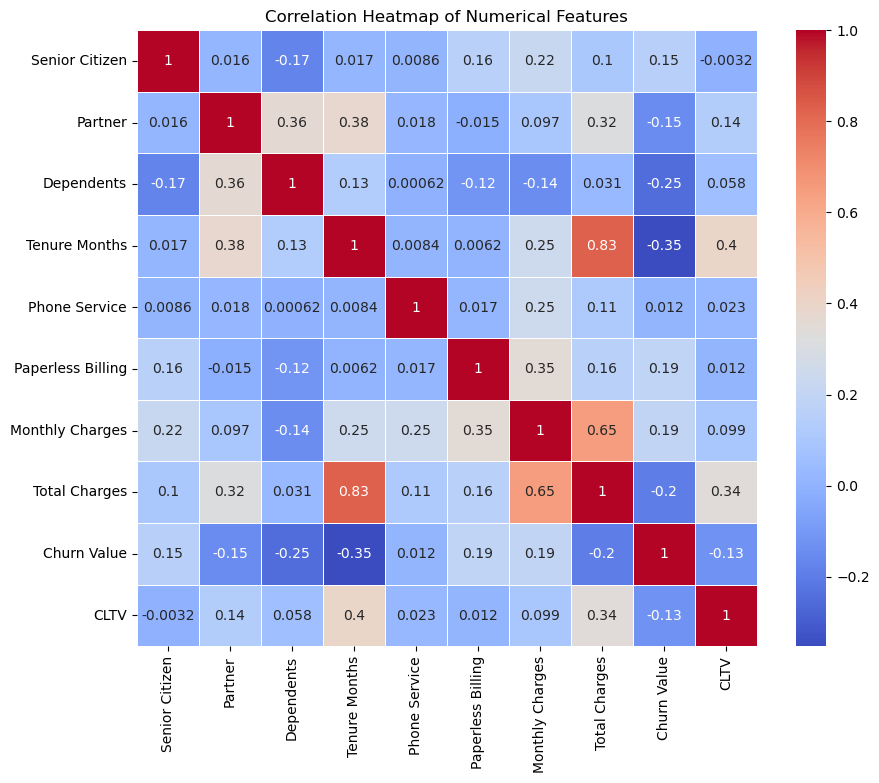

Skewness of Senior Citizen: 1.83 - Right Skewed (Positive Skew)
Skewness of Partner: 0.07 - Right Skewed (Positive Skew)
Skewness of Dependents: 1.28 - Right Skewed (Positive Skew)
Skewness of Tenure Months: 0.24 - Right Skewed (Positive Skew)
Skewness of Phone Service: -2.73 - Left Skewed (Negative Skew)
Skewness of Paperless Billing: -0.38 - Left Skewed (Negative Skew)
Skewness of Monthly Charges: -0.22 - Left Skewed (Negative Skew)
Skewness of Total Charges: 0.96 - Right Skewed (Positive Skew)
Skewness of Churn Value: 1.06 - Right Skewed (Positive Skew)
Skewness of CLTV: -0.31 - Left Skewed (Negative Skew)


In [12]:
# List of numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()

# Plotting histograms for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[col], bins=30, color='blue')  # No KDE here
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Boxplots for all numerical features to detect outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# 3. Pairplot to see relationships between numerical features
sns.pairplot(data[numerical_cols])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# 4. Correlation Heatmap
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# 5. Checking Skewness of numerical features
for col in numerical_cols:
    col_skewness = skew(data[col], nan_policy='omit')  # Ignore NaN values if any
    if col_skewness > 0:
        skew_type = 'Right Skewed (Positive Skew)'
    elif col_skewness < 0:
        skew_type = 'Left Skewed (Negative Skew)'
    else:
        skew_type = 'Normally Distributed (No Skew)'
    
    print(f'Skewness of {col}: {col_skewness:.2f} - {skew_type}')



In [13]:
# # Assuming 'data' is your dataset and 'Churn Value' is your target variable
# # Encode categorical features if they are not numeric
# le = LabelEncoder()
# data_encoded = data.apply(le.fit_transform)

# # Split dataset into X (features) and y (target variable)
# X = data_encoded.drop('Churn Value', axis=1)
# y = data_encoded['Churn Value']

# # Apply Chi-Square test
# chi2_vals, p_vals = chi2(X, y)

# # Create a DataFrame for p-values and features
# p_value_df = pd.DataFrame({
#     'Feature': X.columns,
#     'P-Value': p_vals
# })

# # Sort by p-value
# p_value_df = p_value_df.sort_values(by='P-Value', ascending=True)

# # Show features with significant p-values (typically < 0.05)
# print(p_value_df)


In [14]:
# Features like Gender and Phone Service have high p-values, indicating that they are not significantly related to churn and might be dropped.
# data = data.drop(columns=['Gender', 'Phone Service', 'Internet Service', 'Streaming Movies', 'Streaming TV', 'Multiple Lines'])

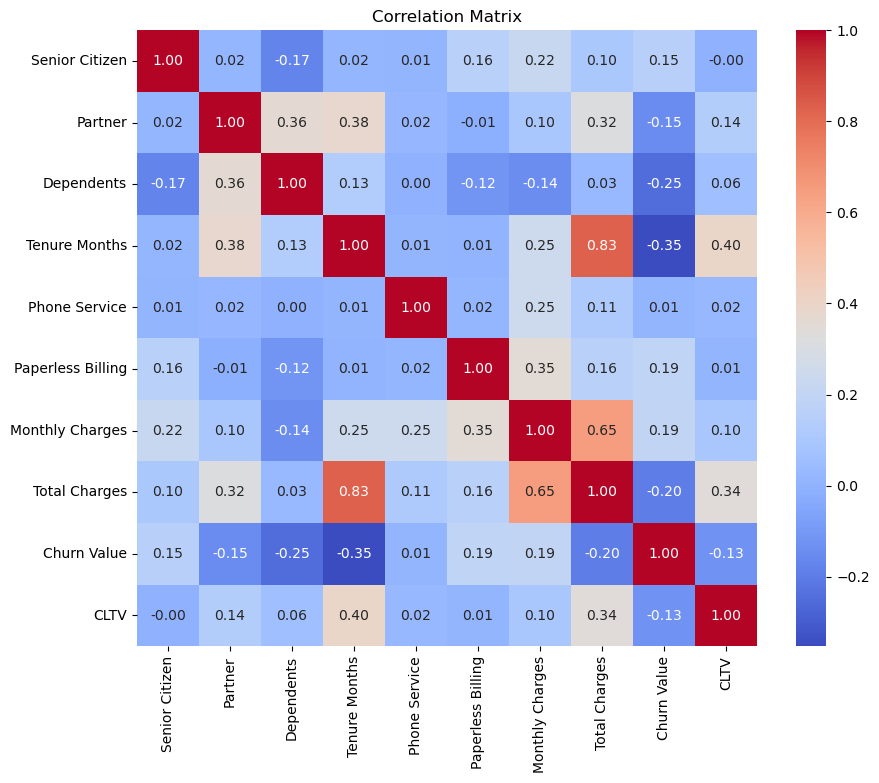

In [15]:
# Get numeric columns only
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Class Distribution:
Churn Value
0    5174
1    1869
Name: count, dtype: int64

Class Percentage:
Churn Value
0    73.463013
1    26.536987
Name: count, dtype: float64


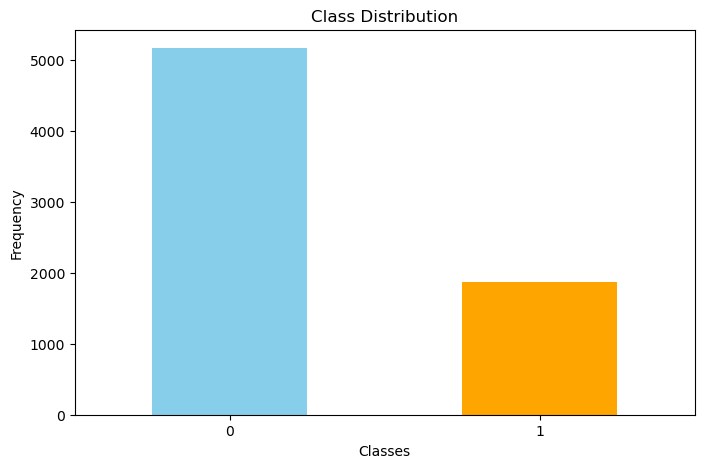

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Assuming your labels are in a column named 'target'
y = data['Churn Value'] 
# Replace 'target' with the actual name of your label column
class_distribution = y.value_counts()

# Print class distribution
print("Class Distribution:")
print(class_distribution)

# Calculate class percentages
class_percentage = class_distribution / len(y) * 100
print("\nClass Percentage:")
print(class_percentage)

# Visualize the class imbalance
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import skew

# # Assuming 'data' is your dataframe and X contains your feature columns
# # (excluding the target variable 'Churn Value')
# X = data.drop(columns=['Churn Value'])

# # Select only numeric columns for skewness calculation
# X_numeric = X.select_dtypes(include=['float64', 'int64'])

# # Function to plot histograms and calculate skewness
# def plot_histograms_and_skewness(X):
#     skew_values = {}
    
#     plt.figure(figsize=(15, 10))
#     for i, column in enumerate(X.columns):
#         plt.subplot(4, 4, i + 1)
#         sns.histplot(X[column], kde=True)
#         plt.title(f"Feature: {column}\nSkewness: {round(skew(X[column]), 2)}")
        
#         # Calculate skewness for each feature
#         skew_values[column] = skew(X[column])
    
#     plt.tight_layout()
#     plt.show()
    
#     return skew_values

# # Plot histograms and calculate skewness
# skew_values = plot_histograms_and_skewness(X_numeric)

# # Print skewness values
# print("\nSkewness of each feature:")
# for column, value in skew_values.items():
#     print(f"{column}: {value}")

# # Determine if a feature is skewed or normally distributed
# for column, value in skew_values.items():
#     if abs(value) < 0.5:
#         print(f"\nFeature '{column}' is approximately normal and StandardScaler is a good choice.")
#     else:
#         print(f"\nFeature '{column}' is skewed and MinMaxScaler might be a better choice.")


In [18]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# # Initialize scalers
# min_max_scaler = MinMaxScaler()
# standard_scaler = StandardScaler()

# # Apply MinMaxScaler and StandardScaler based on the skewness results
# X_scaled = X.copy()  # Assuming X is your feature matrix

# # Apply MinMaxScaler to skewed features
# X_scaled[['Senior Citizen', 'Dependents', 'Phone Service', 'Total Charges']] = min_max_scaler.fit_transform(
#     X[['Senior Citizen', 'Dependents', 'Phone Service', 'Total Charges']])

# # Apply StandardScaler to approximately normal features
# X_scaled[['Partner', 'Tenure Months', 'Paperless Billing', 'Monthly Charges', 'CLTV']] = standard_scaler.fit_transform(
#     X[['Partner', 'Tenure Months', 'Paperless Billing', 'Monthly Charges', 'CLTV']])


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Assuming 'data' is your dataset and 'Churn Value' is your target variable
# Encode categorical features if they are not numeric
le = LabelEncoder()
data_encoded = data.apply(le.fit_transform)

# Split dataset into X (features) and y (target variable)
X = data_encoded.drop('Churn Value', axis=1)
y = data_encoded['Churn Value']

# Define a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    # Print model performance
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Print a summary of results
print("\nSummary of Accuracies:")
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.2f}")

Model: Logistic Regression
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1525
           1       0.55      0.80      0.65       588

    accuracy                           0.76      2113
   macro avg       0.73      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113

Confusion Matrix:
 [[1133  392]
 [ 118  470]]
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1525
           1       0.57      0.77      0.65       588

    accuracy                           0.77      2113
   macro avg       0.73      0.77      0.74      2113
weighted avg       0.80      0.77      0.78      2113

Confusion Matrix:
 [[1180  345]
 [ 137  451]]
----------------------------------------------------------

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Set the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Train with the best parameters
best_rf = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_rf.predict(X_train_smote)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy: 0.865863558263776


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use the best parameters obtained from GridSearchCV
best_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 
               'min_samples_split': 2, 'n_estimators': 300}

# Initialize Random Forest with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
# rf_best = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')

# Train the model on the SMOTE data
rf_best.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf_best = rf_best.predict(X_test_scaled)

# Calculate accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Random Forest with Best Parameters Accuracy: {accuracy_rf_best:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred_rf_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))

Random Forest with Best Parameters Accuracy: 0.7908
Classification Report for Random Forest with Best Parameters:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1525
           1       0.62      0.66      0.64       588

    accuracy                           0.79      2113
   macro avg       0.74      0.75      0.75      2113
weighted avg       0.80      0.79      0.79      2113

Confusion Matrix:
[[1281  244]
 [ 198  390]]


              Feature  Importance
14           Contract    0.125806
17    Monthly Charges    0.110481
18      Total Charges    0.103677
4       Tenure Months    0.101907
19               CLTV    0.095683
8     Online Security    0.080478
11       Tech Support    0.075433
3          Dependents    0.056395
9       Online Backup    0.036842
16     Payment Method    0.034093
7    Internet Service    0.030251
10  Device Protection    0.025296
2             Partner    0.024815
0              Gender    0.019570
6      Multiple Lines    0.016701
12       Streaming TV    0.015105
15  Paperless Billing    0.014919
13   Streaming Movies    0.014756
1      Senior Citizen    0.012015
5       Phone Service    0.005779


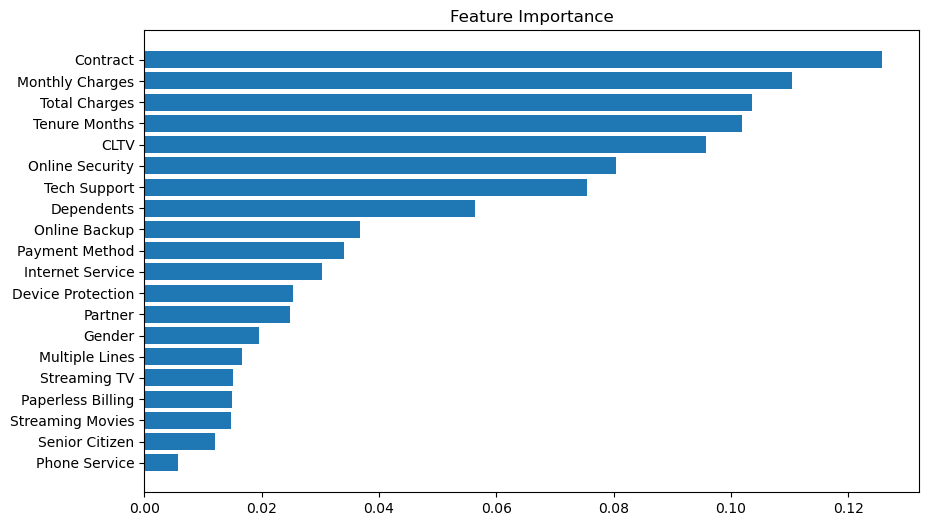

In [22]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assuming that 'X_train' is your original feature set and 'y_train' is your target variable
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Get feature importance
importances = rf.feature_importances_

# Make sure to get the columns of X_train_smote, not X_train
feature_names = X_train_smote.columns

# Create a DataFrame with feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [27]:
# List of features to drop based on low importance
features_to_drop = ['Phone Service', 'Senior Citizen', 'Streaming Movies', 'Paperless Billing', 'Streaming TV', 
                    'Multiple Lines']

# Remove the features directly from the original X_train and X_test variables
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

# Print the new shapes of the datasets
print("Shape of X_train after dropping features:", X_train.shape)
print("Shape of X_test after dropping features:", X_test.shape)


Shape of X_train after dropping features: (4930, 14)
Shape of X_test after dropping features: (2113, 14)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Use the best parameters obtained from GridSearchCV
best_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 
               'min_samples_split': 2, 'n_estimators': 300}

# Initialize Random Forest with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the updated SMOTE data (make sure X_train_smote_scaled and y_train_smote are correctly defined)
rf_best.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf_best = rf_best.predict(X_test_scaled)

# Calculate accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Random Forest with Best Parameters Accuracy: {accuracy_rf_best:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred_rf_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))


# Random Forest with Best Parameters Accuracy: 0.7908
# Classification Report for Random Forest with Best Parameters:
#               precision    recall  f1-score   support

#            0       0.87      0.83      0.85      1525
#            1       0.61      0.68      0.64       588

#     accuracy                           0.79      2113
#    macro avg       0.74      0.76      0.75      2113
# weighted avg       0.80      0.79      0.79      2113

# Confusion Matrix:
# [[1273  252]
#  [ 190  398]]

Random Forest with Best Parameters Accuracy: 0.7866
Classification Report for Random Forest with Best Parameters:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1525
           1       0.60      0.70      0.65       588

    accuracy                           0.79      2113
   macro avg       0.74      0.76      0.75      2113
weighted avg       0.80      0.79      0.79      2113

Confusion Matrix:
[[1251  274]
 [ 177  411]]


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Feature Engineering: Create interaction term between Monthly Charges and Tenure Months
X_train['MonthlyCharges_Tenure'] = X_train['Monthly Charges'] * X_train['Tenure Months']
X_test['MonthlyCharges_Tenure'] = X_test['Monthly Charges'] * X_test['Tenure Months']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Use the best parameters obtained from GridSearchCV
best_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 
               'min_samples_split': 2, 'n_estimators': 300}

# Initialize Random Forest with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the updated SMOTE data (make sure X_train_smote and y_train_smote are correctly defined)
rf_best.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf_best = rf_best.predict(X_test_scaled)

# Calculate accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Random Forest with Best Parameters Accuracy: {accuracy_rf_best:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred_rf_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))


Random Forest with Best Parameters Accuracy: 0.7894
Classification Report for Random Forest with Best Parameters:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1525
           1       0.60      0.71      0.65       588

    accuracy                           0.79      2113
   macro avg       0.74      0.76      0.75      2113
weighted avg       0.80      0.79      0.79      2113

Confusion Matrix:
[[1253  272]
 [ 173  415]]


In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Define the hyperparameters to sample from
param_dist = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],    # Min samples per leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train_smote, y_train_smote)

# Best parameters found by RandomizedSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Use the best estimator to make predictions
best_rf = random_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest with Best Parameters Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Random Forest with Best Parameters Accuracy: 0.7799
Classification Report for Random Forest with Best Parameters:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1525
           1       0.59      0.68      0.63       588

    accuracy                           0.78      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.79      0.78      0.78      2113

Confusion Matrix:
[[1250  275]
 [ 190  398]]


In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance using BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize XGBoost model with default parameters (tune later if needed)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_smote) - sum(y_train_smote)) / sum(y_train_smote), 
                              use_label_encoder=False)

# Train the model on the SMOTE data
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7814
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1525
           1       0.59      0.69      0.64       588

    accuracy                           0.78      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.79      0.78      0.79      2113

Confusion Matrix:
[[1243  282]
 [ 180  408]]


In [38]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, (len(y_train_smote) - sum(y_train_smote)) / sum(y_train_smote)]  # Adjust for class imbalance
}

# Initialize XGBoost classifier without use_label_encoder
xgb_model = xgb.XGBClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from the search
print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")

# Predict with the best model
y_pred_xgb_best = random_search.predict(X_test_scaled)

# Calculate accuracy
accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"XGBoost with Best Parameters Accuracy: {accuracy_xgb_best:.4f}")

# Classification report
print("Classification Report for XGBoost with Best Parameters:")
print(classification_report(y_test, y_pred_xgb_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters from RandomizedSearchCV: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
XGBoost with Best Parameters Accuracy: 0.7856
Classification Report for XGBoost with Best Parameters:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      1525
           1       0.59      0.72      0.65       588

    accuracy                           0.79      2113
   macro avg       0.74      0.77      0.75      2113
weighted avg       0.80      0.79      0.79      2113

Confusion Matrix:
[[1237  288]
 [ 165  423]]


In [41]:

# Define a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    # Print model performance
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Print a summary of results
print("\nSummary of Accuracies:")
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.2f}")

Model: Logistic Regression
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1525
           1       0.53      0.82      0.65       588

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.75      0.76      2113

Confusion Matrix:
 [[1105  420]
 [ 107  481]]
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1525
           1       0.52      0.83      0.64       588

    accuracy                           0.74      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.74      0.75      2113

Confusion Matrix:
 [[1079  446]
 [ 101  487]]
----------------------------------------------------------

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Feature Engineering: Create interaction term between Monthly Charges and Tenure Months
X_train['MonthlyCharges_Tenure'] = X_train['Monthly Charges'] * X_train['Tenure Months']
X_test['MonthlyCharges_Tenure'] = X_test['Monthly Charges'] * X_test['Tenure Months']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Use the best parameters obtained from GridSearchCV
best_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 
               'min_samples_split': 2, 'n_estimators': 300}

# Initialize Random Forest with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the updated SMOTE data (make sure X_train_smote and y_train_smote are correctly defined)
rf_best.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf_best = rf_best.predict(X_test_scaled)

# Calculate accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Random Forest with Best Parameters Accuracy: {accuracy_rf_best:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred_rf_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Define the hyperparameters to sample from
param_dist = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],    # Min samples per leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train_smote, y_train_smote)

# Best parameters found by RandomizedSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Use the best estimator to make predictions
best_rf = random_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest with Best Parameters Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report for Random Forest with Best Parameters:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance using BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize XGBoost model with default parameters (tune later if needed)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_smote) - sum(y_train_smote)) / sum(y_train_smote), 
                              use_label_encoder=False)

# Train the model on the SMOTE data
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, (len(y_train_smote) - sum(y_train_smote)) / sum(y_train_smote)]  # Adjust for class imbalance
}

# Initialize XGBoost classifier without use_label_encoder
xgb_model = xgb.XGBClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from the search
print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")

# Predict with the best model
y_pred_xgb_best = random_search.predict(X_test_scaled)

# Calculate accuracy
accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"XGBoost with Best Parameters Accuracy: {accuracy_xgb_best:.4f}")

# Classification report
print("Classification Report for XGBoost with Best Parameters:")
print(classification_report(y_test, y_pred_xgb_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_best))


# Define a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    # Print model performance
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Print a summary of results
print("\nSummary of Accuracies:")
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.2f}")